# Домашнее задание 2. Бонус

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/My\ Drive/dataset.zip 

In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 9.9MB/s 
     |████████████████████████████████| 952kB 19.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=cece7a6958e4d185884edb7111353594b64b872dfee5bce246afcc98914f6cf2
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
#IMPORTS
import sys
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import random

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2, ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_transform_no_resize = A.Compose(
    [
        A.PadIfNeeded(min_height=32, min_width=32, value=4),
        A.RandomCrop(height=28, width=28),
        A.Flip(),
        A.Normalize(),
        ToTensorV2()
    ]
)

val_transform_no_resize = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

train_no_resize_func = lambda img: train_transform_no_resize(image=np.array(img))
val_no_resize_func = lambda img: val_transform_no_resize(image=np.array(img))
# YOU CAN DEFINE AUGMENTATIONS HERE

train_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/train", transform=train_no_resize_func)
val_dataset = torchvision.datasets.ImageFolder("./dataset/dataset/val", transform=val_no_resize_func)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset

Посмотрим как выглядят картинки с предложенной аугментацией:

In [ ]:
sample_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=32, min_width=32, value=4),
        A.RandomCrop(height=32, width=32),
        A.Flip(),
        A.CoarseDropout(max_holes=1, max_height=10, max_width=10),
        #A.Normalize(),
    ]
)

def visualize_before_after():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    image = cv2.imread("./dataset/dataset/train/class_191/00002.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    image = sample_transform(image=image)['image']
    ax[1].imshow(image)

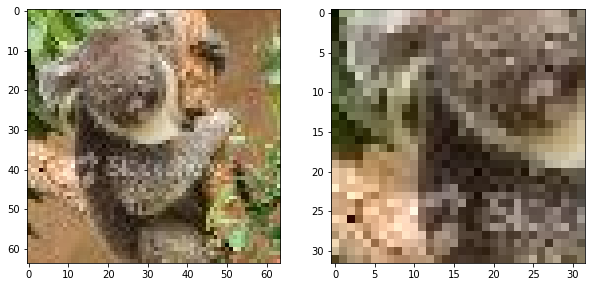

In [ ]:
# SAMPLE VISUALIZATION
visualize_before_after()

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
dataloader_handler = {
    "train": torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
}

In [ ]:
train_loss = []
train_acc = []
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
      for inputs, labels in train_dataloader:
        inputs = inputs['image'].to(device)
        labels = labels.to(device)
        outputs = model(inputs) # feed forward
        optimizer.zero_grad()
        acc = (outputs.argmax(1) == labels).float().mean() # accuracy(outputs, labels), compute accuracy
        loss = criterion(outputs, labels) # compute loss
        loss.backward()
        optimizer.step()
        prbar.set_description(
            "batch tloss: %.4f, batch tacc: %.4f" % (loss.item(), acc.item())
        ) 
        prbar.update(1)
        train_loss.append(loss.cpu().detach().item())
        train_acc.append(acc.cpu().detach().item())

@torch.no_grad()
def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.to(device) # prevent errors when using single function outside training loop
    losses = []
    true_classes = np.array([])
    predicted_classes = np.array([])
    model.eval()
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for inputs, labels in val_dataloader:
            inputs = inputs['image'].to(device)
            labels = labels.to(device)
            outputs = model(inputs) # feed forward
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()
            losses.append(loss.item())
            prbar.set_description(
                "batch vloss: %.4f, batch vacc: %.4f" % (loss.item(), acc.item())
            ) 
            prbar.update(1)
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            predicted_classes = np.append(predicted_classes, outputs.argmax(1).cpu().detach().numpy())
    return np.array(losses), predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    e_loss = []
    e_acc = []
    for epoch in range(n_epochs):
        print("Epoch[%d] training..." % epoch)
        train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device)
        mean_loss = losses.mean()
        metrics = (mean_loss, (predicted_classes == true_classes).mean())
        if scheduler:
            scheduler.step()
        print("epoch loss: %.4f, epoch acc: %.4f" % (metrics[0], metrics[1]))
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...
        e_loss.append(metrics[0])
        e_acc.append(metrics[1])
    return e_loss, e_acc


In [ ]:
import torchvision.models as models

In [ ]:
torch.manual_seed(42)

In [ ]:
class ModifiedResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False # use it instead of maxpool and change kernel size to lower 3x3 instead of 7x7
        )
        self.resnet.maxpool = torch.nn.Identity()
        self.resnet.fc = nn.Linear(512, 200)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
resnet18 = ModifiedResNet18()

In [ ]:
model = resnet18 # THE MODEL THAT YOU CHOOSE
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZER
train_dataloader = dataloader_handler['train'] # TRAIN DATALOADER WHICH YOU CONSTRUCT
val_dataloader = dataloader_handler['val'] # VAL DATALOADER WHICH YOU CONSTRUCT
criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss() # LOSS THAT YOU OPTIMIZE (SHOLD BE CROSS ENTROPY OR SMTH ELSE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = 50 # NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)
print("tests passed")

batch vloss: 7.3624, batch vacc: 0.0000: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
10000 10000
0.005
tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 4.7218, batch vacc: 0.0551: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 4.6201, epoch acc: 0.0515
Epoch[1] training...
batch vloss: 4.0304, batch vacc: 0.1250: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
epoch loss: 4.1185, epoch acc: 0.1271
Epoch[2] training...
batch vloss: 3.6259, batch vacc: 0.1618: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
epoch loss: 4.1132, epoch acc: 0.1197
Epoch[3] training...
batch vloss: 3.3528, batch vacc: 0.3162: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 3.8028, epoch acc: 0.1628
Epoch[4] training...
batch vloss: 3.2909, batch vacc: 0.3125: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
epoch loss: 3.7269, epoch acc: 0.1827
Epoch[5] training...
batch vloss: 3.4360, batch vacc: 0.3235: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 3.6221, epoch acc: 0.2058
Epoch[6] training...
batch vloss: 3.2864, batch vacc: 0.2537: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
ep

([4.620053815841675,
  4.118547737598419,
  4.1132360935211185,
  3.802778720855713,
  3.7269425868988035,
  3.6220829486846924,
  3.705846679210663,
  3.5791345953941347,
  3.5088521003723145,
  3.4667664408683776,
  3.3669970512390135,
  3.2922337532043455,
  3.266925942897797,
  3.265609693527222,
  3.2877191424369814,
  3.2515648722648622,
  3.170326018333435,
  3.1584096550941467,
  3.3323511242866517,
  3.254070246219635,
  2.6742778062820434,
  2.5938212633132935,
  2.560631000995636,
  2.503417432308197,
  2.4836806058883667,
  2.4709431409835814,
  2.4529536247253416,
  2.461648499965668,
  2.4048771500587462,
  2.427120441198349,
  2.3690937399864196,
  2.3981608152389526,
  2.3820932865142823,
  2.3575494647026063,
  2.3348562955856322,
  2.3472585439682008,
  2.2976770043373107,
  2.3228366494178774,
  2.3144198060035706,
  2.3244169116020204,
  2.194264602661133,
  2.1670078456401827,
  2.1542411923408507,
  2.1430228412151338,
  2.1386182367801667,
  2.131634521484375,
  

In [ ]:
# accuracy after 50 epochs
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)

batch vloss: 2.0426, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
10000 10000
0.5419


In [ ]:
# change number of epochs and hope for the best (total is 50 + 20 = 70)
n_epochs = 20
# change lr (previous was 0.05 at start of the training, but reduced to 0.0005 due to scheduler)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZER
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,13], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 2.0430, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
epoch loss: 2.1156, epoch acc: 0.5379
Epoch[1] training...
batch vloss: 2.0484, batch vacc: 0.5294: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
epoch loss: 2.0947, epoch acc: 0.5425
Epoch[2] training...
batch vloss: 2.0353, batch vacc: 0.5515: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
epoch loss: 2.0927, epoch acc: 0.5420
Epoch[3] training...
batch vloss: 2.0191, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
epoch loss: 2.1038, epoch acc: 0.5435
Epoch[4] training...
batch vloss: 2.0046, batch vacc: 0.5662: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
epoch loss: 2.1012, epoch acc: 0.5409
Epoch[5] training...
batch vloss: 2.0071, batch vacc: 0.5699: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
epoch loss: 2.0868, epoch acc: 0.5456
Epoch[6] training...
batch vloss: 2.0073, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
ep

([2.115617793798447,
  2.094724100828171,
  2.092661589384079,
  2.1037700355052946,
  2.1012390494346618,
  2.086758667230606,
  2.0872295260429383,
  2.0906174004077913,
  2.08331583738327,
  2.091127133369446,
  2.078837013244629,
  2.071694868803024,
  2.076632869243622,
  2.0779599964618685,
  2.0797977685928344,
  2.064708250761032,
  2.0766901910305022,
  2.0807956755161285,
  2.070765030384064,
  2.0753883838653566],
 [0.5379,
  0.5425,
  0.542,
  0.5435,
  0.5409,
  0.5456,
  0.5469,
  0.5437,
  0.5456,
  0.5449,
  0.5464,
  0.5475,
  0.548,
  0.5443,
  0.5475,
  0.5466,
  0.549,
  0.545,
  0.5469,
  0.5467])

In [ ]:
# accuracy after 70 epochs
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)

batch vloss: 1.9636, batch vacc: 0.5735: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
10000 10000
0.5467


In [ ]:
# try to increase lr a bit and decrease again
# change number of epochs and hope for the best (total is 70 + 20 = 90)
n_epochs = 20
# change lr (previous was 0.000005 after all schedulers worked)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0008, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZER
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,13], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 2.0385, batch vacc: 0.5368: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
epoch loss: 2.0831, epoch acc: 0.5442
Epoch[1] training...
batch vloss: 2.0608, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0605, epoch acc: 0.5434
Epoch[2] training...
batch vloss: 1.9597, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
epoch loss: 2.0710, epoch acc: 0.5431
Epoch[3] training...
batch vloss: 1.9974, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
epoch loss: 2.0767, epoch acc: 0.5361
Epoch[4] training...
batch vloss: 2.0508, batch vacc: 0.5404: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
epoch loss: 2.0742, epoch acc: 0.5374
Epoch[5] training...
batch vloss: 2.0342, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0696, epoch acc: 0.5449
Epoch[6] training...
batch vloss: 2.0072, batch vacc: 0.5368: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
ep

([2.0831023156642914,
  2.060468065738678,
  2.071043002605438,
  2.0767474114894866,
  2.0742180585861205,
  2.0695657253265383,
  2.0428754687309265,
  2.0421570420265196,
  2.0502575814723967,
  2.0411776065826417,
  2.044291985034943,
  2.0338232576847077,
  2.051021361351013,
  2.043023157119751,
  2.041088891029358,
  2.0264786541461945,
  2.0273510575294496,
  2.0485211610794067,
  2.048312747478485,
  2.0349574625492095],
 [0.5442,
  0.5434,
  0.5431,
  0.5361,
  0.5374,
  0.5449,
  0.5472,
  0.5484,
  0.5477,
  0.5517,
  0.5499,
  0.5539,
  0.5504,
  0.5503,
  0.55,
  0.5526,
  0.5508,
  0.5499,
  0.5492,
  0.5551])

In [ ]:
# try hard once again (increase and decrease once)
# change number of epochs and hope for the best (total is 90 + 20 = 110)
n_epochs = 20
# change lr (previous was 0.000008)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00008, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZE
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 1.9858, batch vacc: 0.5404: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
epoch loss: 2.0383, epoch acc: 0.5531
Epoch[1] training...
batch vloss: 1.9726, batch vacc: 0.5625: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
epoch loss: 2.0426, epoch acc: 0.5506
Epoch[2] training...
batch vloss: 1.9972, batch vacc: 0.5441: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
epoch loss: 2.0316, epoch acc: 0.5535
Epoch[3] training...
batch vloss: 1.9880, batch vacc: 0.5478: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0325, epoch acc: 0.5510
Epoch[4] training...
batch vloss: 2.0027, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
epoch loss: 2.0374, epoch acc: 0.5527
Epoch[5] training...
batch vloss: 1.9990, batch vacc: 0.5441: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 2.0299, epoch acc: 0.5510
Epoch[6] training...
batch vloss: 1.9720, batch vacc: 0.5515: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]
ep

([2.038334387540817,
  2.042556118965149,
  2.0315613031387327,
  2.0325495421886446,
  2.037391424179077,
  2.0299007892608643,
  2.028788465261459,
  2.034645140171051,
  2.028744751214981,
  2.0380656480789185,
  2.035568428039551,
  2.036299777030945,
  2.028529042005539,
  2.0330076456069945,
  2.043207365274429,
  2.0271693766117096,
  2.03148358464241,
  2.029901909828186,
  2.0202405869960787,
  2.0247882902622223],
 [0.5531,
  0.5506,
  0.5535,
  0.551,
  0.5527,
  0.551,
  0.55,
  0.5504,
  0.5564,
  0.5515,
  0.5535,
  0.5503,
  0.5508,
  0.5511,
  0.5486,
  0.5544,
  0.5521,
  0.5499,
  0.5545,
  0.5528])

In [ ]:
# try hard once again (increase and decrease once)
# change number of epochs and hope for the best (total is 110 + 50 = 160)
n_epochs = 50
# change lr (previous was 0.000008)
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.9, weight_decay=5e-4) # YOUR OPTIMIZE
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1) # LR SCHEDULE THAT YOU PROBABLY CHOOSE

In [ ]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Epoch[0] training...
batch vloss: 2.3232, batch vacc: 0.4485: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
epoch loss: 2.4885, epoch acc: 0.4371
Epoch[1] training...
batch vloss: 2.2122, batch vacc: 0.5037: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 2.4354, epoch acc: 0.4528
Epoch[2] training...
batch vloss: 2.3789, batch vacc: 0.4559: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
epoch loss: 2.3519, epoch acc: 0.4754
Epoch[3] training...
batch vloss: 2.4132, batch vacc: 0.4191: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
epoch loss: 2.3766, epoch acc: 0.4656
Epoch[4] training...
batch vloss: 2.1662, batch vacc: 0.5184: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
epoch loss: 2.3481, epoch acc: 0.4754
Epoch[5] training...
batch vloss: 2.4827, batch vacc: 0.4154: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
epoch loss: 2.3302, epoch acc: 0.4828
Epoch[6] training...
batch vloss: 2.1878, batch vacc: 0.5221: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
ep

([2.4884654879570007,
  2.4354085326194763,
  2.3518980979919433,
  2.3765501022338866,
  2.3481061935424803,
  2.330153787136078,
  2.3718225598335265,
  2.35806941986084,
  2.33378427028656,
  2.349356460571289,
  2.3376346826553345,
  2.2725826859474183,
  2.297279065847397,
  2.2704860091209413,
  2.285806667804718,
  2.2731137573719025,
  2.2917776226997377,
  2.209756338596344,
  2.2370642840862276,
  2.2810950458049772,
  2.0164288878440857,
  1.9905426800251007,
  1.9709449112415314,
  1.9541387259960175,
  1.9483651578426362,
  1.929926908016205,
  1.9285638272762298,
  1.9151043713092804,
  1.9087697327136994,
  1.893426352739334,
  1.8973443329334259,
  1.8878269731998443,
  1.8930960178375245,
  1.8870680153369903,
  1.8832656621932984,
  1.8770473718643188,
  1.8770743787288666,
  1.8787112057209014,
  1.8631231844425202,
  1.8703285336494446,
  1.8521351099014283,
  1.8485256493091584,
  1.8458992779254912,
  1.846769279241562,
  1.838661104440689,
  1.8371204257011413,
 

In [ ]:
# accuracy after 160 epochs
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
print(len(predicted_labels), len(val_dataset))
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print(accuracy)

batch vloss: 1.8594, batch vacc: 0.5625: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
10000 10000
0.5862


Сохраним модель. 

In [ ]:
PATH = "/content/drive/MyDrive/resnet18-200.tar"
torch.save({
            'epoch': 160,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

Вычислим чексумму тар-файла. К решению будет приложен сам tar-file, чтобы была возможность проверить модель на факт изменений.

In [ ]:
! pwd

/content


In [ ]:
! shasum -a 512 /content/drive/MyDrive/resnet18-200.tar > ./model_checksum.txt

In [ ]:
! cat model_checksum.txt

823b17566a73c391de49457ce287e071054df3a793666a7ce16130d7968b836d055b97ca000704ce2fb1de62d75b658854e784acd0348c8cc7796d93b58e0f49  /content/drive/MyDrive/resnet18-200.tar


Достаточно будет скачать приложенный tar-file и запусить команду `shasum -a 512 path_to_file`, где path_to_file - путь к скачанному тар-файлу и сравнить чексумму, приложенную здесь с локальной версией.

__Ваш отчёт о проделанных экспериментах__:

Будем пользоваться трюками, которые предлагаются для улучшения качества для Cifar. 

Аугментации:


*   **Padding** (если картинка меньше 32х32, то дополнить картинку до необходимого размера). Если честно, есть ощущение, что на самом деле все картинки имеют размерность большую 32х32, поэтому на самом деле эта аугментация ничего не делает. Значение 4 в поле value на самом деле тоже является взятым наугад в непонимании того, как устроена функция PadIfNeeded из библиотеки Albumentations. В общем, ее скорее всего можно убрать.
*   **Random Crop**. Уменьшаем размер картинки до 28х28. Я делал его в предположении, что в датасете находятся картинки в том числе и довольно маленького размера (меньшего чем 64х64). Чтобы мы либо захватывали почти все изображение, потому что для меньшего размера сетке будет сложно вычленить достаточное количество признаков. Обучение будет происходить быстрее, из-за меньших размеров.

* **Flip**. Для разнообразия и от переобучения.

* **Normalize**. Чтобы избежать "взрыв градиента" и для более быстрой оптимизации.

*Honorable mention*:


*   **CoarseDropout**. Вырезаем часть картинки, для предотвращения переобучения. Если честно, модель вместе с ним не добивалась необходимого результата, но была очень близка к нему (~0.54 accuracy). Для картинок большего размера, эффект был бы выше.

Остальное многообразие аугментаций я не использовал, поскольку размер картинки довольно маленький. И всевозможные сдвиги, ротации и сдвиги цветовой гаммы мне не давали нужного результата. Возможно, я упустил какие-то интересные идеи, которые существуют конкретно для данного датасета без использования resize и буду рад знать о каких-либо других подходах и решениях проблемы.













Относительно реализации батчлоадера, используем более мелкий для трейна и более большой для валидации. Принципиального объяснения для этого нет. Хотелось чтобы эпоха занимала ~1 минуты, а валидация проходила быстрее. Похожих результатов получилось добиваться и с одинаковыми и с более мелкими батчами.

Самое важное здесь это класс – ModifiedResNet18, который нужен нам для модификации ResNet модели. 

```
class ModifiedResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.resnet.maxpool = torch.nn.Identity()
        self.resnet.fc = nn.Linear(512, 200)

    def forward(self, x):
        x = self.resnet(x)
        return x
```

Суть в том, что в архитекутре resnet18 из torchvision.models первый сверточный слой использует ядро размером 7х7 и является слишком большим для извлечения признаков, точнее, захватывает лишь общие признаки, а из-за низкой размерности, да еще и кропа, плюс stride=2 и padding=3, получается не очень удачный feature extraction. По факту первый сверточный слой в resnet18 заменяет несколько сверток 3х3 для ускорения обучения, что действительно имеет смысл на картинках большего размера После сверточного слоя, батч-нормализации и relu идет maxpool с ядром 3x3, уменьшая картинку до очень маленьких размеров. Опять же мы можем позволить себе большее количеством параметров, так как размеры картинок у нас маленькие. Поэтому maxpool мы можем просто убрать, так как downsampling в нашем случае является лишним.
Некоторые из этих вещей описывают авторы оригинальной статьи о ResNet архитектуре (https://arxiv.org/pdf/1512.03385.pdf) при анализе архитектуры на датасете Cifar.
Последний полносвязный слой меняем в соответствии с количеством классов в нашем датасете.

Теперь относительно обучения:
Используем кросс-энтропию в качестве функции потерь для задачи классификации. Аналогичным образом можно использовать negative log likelihood + softmax.
В качестве оптимизатора используем SGD с начальным lr=0.05 + scheduler, который каждые 20 эпох понижает lr.

Такие параметры позволяют нам добиться качества в 0.54 за первые 50 эпох.
А дальше начинается шаманство, которое не совсем мне понятно.

Дальше мы продолжаем обучение и пытаемся на том же lr, после применения scheduler'a, уменьшить лосс. Возможно, что 15 эпох, это мало, для уменьшения lr, но у меня было четкое ощущение того, что на самом деле SGD скачет вокруг да около и продвинуться дальше не может. Так продолжается с 50 по 90 эпоху. Точнее он застревает в диапазоне 0.55 – 0.56.
Я попытался несколько раз увеличить lr, потому что значения из разряда 5e-6 очень почти не двигают градиент. Но только единственное увеличение до 8e-3, сопровождающееся потерей качества и уменьшением lr через schduler позволили пройти порог в 0.56.

Я руководствовался лишь тем, что lr нужно подкрутить в большую или в меньшую сторону для того, чтобы помочь ему спуститься, при этом слишком большой lr очевидно приводит к тому, что его начинает колбасить по сторонам, а слишком маленький – к тому что он почти не двигается.
Возможно, можно за один заход придумать функцию для lr, которая бы позволила завершить обучение за один цикл, но у меня этого сделать не получилось.

Кроме статьи я руководствовался еще этим кодом, но он мне не особо помог:
https://gist.github.com/y0ast/d91d09565462125a1eb75acc65da1469